In [1]:

import pandas as pd
import numpy as np
import string
import pandas as pd
import pickle
from sklearn.cluster import KMeans,hierarchical,DBSCAN,AgglomerativeClustering

In [2]:
df=pd.read_csv("..\\..\\reviews.csv")

In [ ]:
print(df.shape)
df.dropna(inplace=True)
df=df[df.Score != 3]
positive_or_negative=lambda a: "positive" if ((type(a)== type(2)) and (a > 3)) else "negative"
df['Score']=df['Score'].map(positive_or_negative)
df= df[df.HelpfulnessNumerator<=df.HelpfulnessDenominator]
df.shape

In [99]:
##soring data according product id
df_sorted=df.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

##deduplication of entries
final=df_sorted.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


print(final.shape)

#check how much data is present, len(final['ProductId'])
(final['ProductId'].size*1.0/df['ProductId'].size*1.0)*100

(364159, 10)


69.2616395288461

In [ ]:
final['Score'].value_counts()

In [100]:
##text processing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#print(stop)
print('************************************')
print(sno.stem('tasty'))

************************************
tasti


In [102]:
final['Score'].value_counts()
###taking sample
final_sample= final.sample(frac=0.01)
df_sorted=final_sample.sort_values('Time')
print(df_sorted.shape)


(3642, 10)


In [103]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))
sno = SnowballStemmer('english')

In [104]:
df_sorted['newText']=np.nan
df_sorted.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,newText
149767,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,positive,975974400,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...,NaN


In [105]:
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        final_string=""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                #word=sno(word)
                string += word + " "
        
        df_sorted.loc[index,column] = string
        #print(string)
        #final_string.append(string)

In [106]:
df_sorted['NewText']=None
##slicing for simplicity
#df_sorted=df_sorted.iloc[0:100,:]
for index, row in df_sorted.iterrows():
    nlp_preprocessing(df_sorted['Text'][index], index, 'NewText')

In [107]:
def sent_vect(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            try:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [108]:
##split sentenses to list
list_of_sent=[]
def list_sentense(df_sorted):
    for sent in df_sorted['NewText'].values:
        sentence=sent.split()
        list_of_sent.append(sentence)
    return list_of_sent

list_sentenses=list_sentense(df_sorted)
print(list_sentenses[2])
print(len(list_sentenses))
print(df_sorted['NewText'].shape)


['biting', 'touch', 'cranberry', 'soothing', 'flavor', 'aroma', 'apple', 'reminiscent', 'cranberry', 'cocktail', 'served', 'cold', 'great', 'flavored', 'iced', 'tea', 'hot', 'flake', 'cinnamon', 'drift', 'la', 'la', 'land', 'consume', 'near', 'zero', 'calorie', 'apple', 'pie', 'stuff', 'good']
3642
(3642,)


In [110]:
##creating our own word2vec model
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
w2v_model=gensim.models.Word2Vec(list_sentenses,min_count=5,size=50, workers=4)

In [111]:
print(len(list_sentenses))
df_sorted.shape
df_sorted['list_Sentenses']=list_sentenses
df_sorted.head(1)

3642


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,newText,NewText,list_Sentenses
149767,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,positive,975974400,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...,NaN,sick scads nasty toothpicks counter tinting ic...,"[sick, scads, nasty, toothpicks, counter, tint..."


In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3))
tf_idf = tf_idf_vect.fit_transform(df_sorted['NewText'].values)
tfidf_feat = tf_idf_vect.get_feature_names()
print(len(tfidf_feat))
tfidf_feat[100000:100010]

247400


['got received',
 'got received compliments',
 'got replacement',
 'got replacement little',
 'got responses',
 'got responses sour',
 'got reviews',
 'got reviews minute',
 'got rid',
 'got rid soon']

# KMeans############

In [121]:
from sklearn.cluster import KMeans
Sum_of_squared_distances=[]
n_clusters_range=list(range(1,10))
for i in n_clusters_range:
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(tf_idf)
    Sum_of_squared_distances.append(kmeans.inertia_)

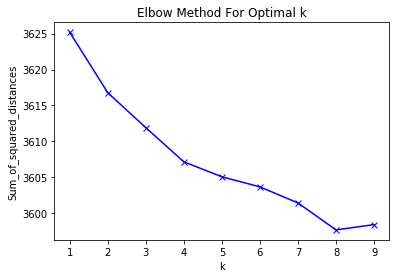

In [129]:
n_clusters_range=list(range(1,10))
plt.plot(n_clusters_range, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [134]:
optimal_clusters=n_clusters_range[np.argmin(Sum_of_squared_distances)]

In [135]:
kmeans=KMeans(n_clusters=optimal_clusters)
kmeans.fit(tf_idf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [136]:
kmeans.labels_

array([1, 1, 3, ..., 1, 1, 4])

In [195]:
df_sorted['labels']=kmeans.labels_
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [143]:
df_sorted.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,newText,NewText,list_Sentenses,labels
149767,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,positive,975974400,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...,NaN,sick scads nasty toothpicks counter tinting ic...,"[sick, scads, nasty, toothpicks, counter, tint...",1


In [196]:
label1=df_sorted['Text'].loc[df_sorted['labels']==1].values
label2=df_sorted['Text'].loc[df_sorted['labels']==2].values
label3=df_sorted['Text'].loc[df_sorted['labels']==3].values
label4=df_sorted['Text'].loc[df_sorted['labels']==4].values
label5=df_sorted['Text'].loc[df_sorted['labels']==5].values
label6=df_sorted['Text'].loc[df_sorted['labels']==6].values
label7=df_sorted['Text'].loc[df_sorted['labels']==7].values


In [179]:
print(label1[1],label1[21],label1[56],sep="\n**********\n")

Ok folks, this is not a joke.  I am a real fan of hot sauce, hot peppers and anything that makes my eyes water, and I have to honestly say that Dave's Insanity Sauce is absolutely the hottest thing I've ever tasted.  I use one drop in about 25 ounces of home-made tomato sauce and it makes the sauce noticibly hot.  This is NOT a sauce to dash into your soup or to liven up some salsa.  DON'T USE IT LIKE TABASCO!!!  It is a heavy-duty hot sauce that should be used as in ingredient when cooking a decent amount of a dish.  My brother doubted its powers so I poked the end of a toothpick into the sauce and gave it to him.  The poor guy freaked and ate more Italian bread than I've ever seen anyone eat in my life.  This bottle will last you a long time.  Why doesn't it get 5 stars?  It's just too hot.
**********
I think that some people have complained that this popcorn is bland, but that's what it's supposed to be.... It's a product that is as healthy as you want it to be- you decide. :)  Alth

In [218]:
print(label2[5],label1[101],label1[150],sep="\n**********\n")

Don't be fooled by the simple packaging of this mixed spice. This is not a simple flavor.<br /><br />If you like the steaks served at a certain "Australian" styled steak house you may well like this seasoning. A friend of mine introduced it to me at a little cook out, where he rubbed a generous amount on some new york strip cuts and grilled, and I fell in love. He then told me that this was the above mentioned steak house's secret seasoning for it's steaks, him claiming to know this by having worked their for a time. I know he had worked at just about every chain restaurant at some point, but that's about all I can confirm in regards to this rumor one way or the other as I've never had a steak there, nor worked at one. Regardless of the truthfullness of that statement, I can firmly attest to fact that this is an excellent mixed spice.<br /><br />I've used it on just about every type of meat except sea food, though I suspect it would be good on that too, with a noteable preformance on e

In [199]:
print(label4[56],label1[44],label1[222],label1[122],sep="\n**********\n")

Despite the fact that the "nutritional information" on Amazon states that this product is only herring, water, and salt, the cans state that GLUTEN is part of the deal.  I am feeding my cans to my dogs, who incidentally love the flavor.<br />BTW, what the hell is gluten doing in a can of fish?
**********
My husband and I have an intense exercise routine and these coconut water drinks are really refreshing afterwards.  The passion fruit flavor is not as sweet as the pinapple, but still tastes fruity.
**********
I purchased these because the picture on the package looked really good.  You would not believe how awful they are.  If you are set on buying them, you will soon find out. The amount of cake you mix up looks like a tablespoon of cake batter and these have trans fat in them.  They taste awful and do absolutely nothing to satisfy a chocolate lover.<br /><br />There is nothing in them.  Waste of money.
**********
The Ener-G Foods English muffins look good in the packaging, but somet

In [185]:
print(label5[99],label5[122],label5[211],sep="\n**********\n")

You can't go wrong with this [[ASIN:B001E5E0D8 Lavazza Crema e Gusto Ground Coffee, Italian Espresso, 8.8-Ounce Bricks (Pack of 4).  Nice espresso flavor, naturally sweet and mild.  It's our favorite everyday espresso  for  morning lattes or an occasional Americano, a nice consistent crema.  And really, you can't beat the Subscribe and Save Program!!  We've tried Lavazza Blu (a chocolate taste) and came back to this.<br /><br />After opening the vacuum sealed package, I transfer the ground espresso to a French (clip top)mason jar, and store in the refrigerator as recommended by the company.  I take out just enough for our two shots and put the jar right back into the fridge--it stays tasting fresh to the last cuppa:~)Delicious!!
**********
I got a few bags of Weaver's Coffee as a gift.  I usually never do reviews but here I am chugging a cup of Weaver's Peru Organic and I just had to write something about this amazing product.  My husband and I are now addicted to this coffee.  It has 

In [186]:
print(label6[167],label6[58],label6[278],sep="\n**********\n")

I have baked this many times in my Breadman with none of the issues the other reviewers had.  Turns our GREAT every time and tastes wonderful.
**********
This item was well packaged and arrived safely and would still look great had my roommate remembered to water it.  It's coming back though which speaks well for the trees general health.
**********
Really enjoy this drink, it works just great!!! And has a nice calming effect.  Great to have after a hard day's work!!!


In [203]:
print(label7[71],label7[36],label7[10],sep="\n**********\n")

This was a great buy on Peter Pan Peanut Butter.  I received my purchase in 2 days.  There is no reason to purchase elsewhere.  <a href="http://www.amazon.com/gp/product/B00295IGHS">Peter Pan Creamy Peanut Butter, 40-Ounce Jars (Pack of 3)</a>
**********
<a href="http://www.amazon.com/gp/product/B000F4DKAI">Twinings English Afternoon Tea, Tea Bags, 20-Count, 1.41 oz. Boxes (Pack of 6)</a><br /><br />This tea is not just for the afternoon. A smoothe mellow tea good anytime of the day and year.  No bitter taste even when it gets cold.  Doesn't even really need  sweetner of any type.
**********
<a href="http://www.amazon.com/gp/product/B000K8ESBO">Flavour Creations Coffee Flavoring Tablets, French Vanilla, 48-Count Dispensers (Pack of 6)</a>Excellent product -- highly recommend.  Used for more than 3 years and am finding it harder and harder to find.


In [194]:
label1=df_sorted['Text'].loc[df_sorted['labels']==1].values
label2=df_sorted['Text'].loc[df_sorted['labels']==2].values
label3=df_sorted['Text'].loc[df_sorted['labels']==3].values
label4=df_sorted['Text'].loc[df_sorted['labels']==4].values
label5=df_sorted['Text'].loc[df_sorted['labels']==5].values
label6=df_sorted['Text'].loc[df_sorted['labels']==6].values
label7=df_sorted['Text'].loc[df_sorted['labels']==7].values

array([0, 1, 2, 3, 4, 5, 6, 7])

In [262]:
df_sorted['kmeans_review']=np.nan


In [264]:
df_sorted.loc[df_sorted.labels == 4  , 'kmeans_review'] = "negative"
df_sorted.loc[df_sorted.labels == 2 ,  'kmeans_review'] = "negative"



In [265]:
df_sorted['kmeans_review']=df_sorted['kmeans_review'].map(lambda x: "positive" if (x != "negative") else x)

In [266]:
df_sorted.kmeans_review.value_counts() 

positive    2889
negative     753
Name: kmeans_review, dtype: int64

In [215]:
df_sorted.Score.value_counts()

positive    3068
negative     574
Name: Score, dtype: int64

# AgglomerativeClustering###

In [283]:
small_df=df_sorted.iloc[1:500]
print(small_df.shape)
small_df.Score.value_counts()

(499, 15)


positive    426
negative     73
Name: Score, dtype: int64

In [284]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3))
tf_idf = tf_idf_vect.fit_transform(small_df['NewText'].values)
tfidf_feat = tf_idf_vect.get_feature_names()
print(len(tfidf_feat))
tfidf_feat[100000:100010]

36289


[]

In [286]:
from sklearn.cluster import AgglomerativeClustering
AgglCluster=AgglomerativeClustering(n_clusters=2)
AgglCluster.fit(tf_idf.toarray())
    

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x0000023AA629C9D8>)

In [288]:
AgglCluster.labels_

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [296]:

small_df.Agg_labels_=AgglCluster.labels_
small_df.Agg_labels_.value_counts()

C:\Users\admin\AppData\Local\Programs\Python\Python36\Lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0    453
1     46
Name: Agg_labels_, dtype: int64

In [298]:
label1=small_df['Text'].loc[small_df['Agg_labels_']==0].values
label2=small_df['Text'].loc[small_df['Agg_labels_']==1].values

In [299]:
print(label1[1],label1[36],label1[10],sep="\n**********\n")

The biting touch of cranberry and the soothing flavor and aroma of apple. Reminiscent of a cranberry cocktail when served cold - a great flavored iced tea - and hot, just flake in some cinnamon and drift off in la-la land as you consume a near zero-calorie apple pie. This stuff is good!
**********
This is the review written by my wife and granddaughter about this microwave treat.<br /><br />"This is a single serving size microwaveable dessert.  You add a little water and empty the mix packet into the bowl and then microwave for about 45 seconds.  Drizzle on the topping and let cool for 2-5 minutes (depending on how warm you want it).  Enjoy right out of the bowl with a fork as is or add a scoop of ice cream.<br /><br />It was chocolaty, yummy, moist and fun to eat.  Yumm!"  My granddaughter, a Dora fan, adds, "Deliciosa!"
**********
I first tried the biscoff cookies on my way to New Orleans. AirTran was serving these as snacks for the travelers. I liked it so much that I decided to ord

In [303]:
print(label2[1],label2[45],label2[25],sep="\n**********\n")

Good is ramune.<br /><br />It tastes BETTER than Sprite.<br /><br />So order it.<br /><br />Because it is good Ramune.<br /><br />Really.
**********
One of our favorite dessert recipes calls for almond paste and the Odense tube is the best for our particular use.<br /><br />Usually I buy it at Safeway, but it costs around $10 per tube there. I checked out Amazon and voil&agrave; -- a six-pack of these puppies comes to a little more than $5 per tube, plus it qualifies for Free SuperSaver Shipping.<br /><br />Now we don't have to wait for a special occasion. We can go ahead and splurge whenever we want to!
**********
This is a very good drink.  Tasty and not syrupy I really enjoyed the flavor.  I tried the Sparkling Clementine.  It is funny when I tasted the drink I thought, yup, that tastes like a Clementine.  Then I looked at the back for the ingredients.  There are juices (from concentrate) from White Grape, Apple, Lemon and Orange Juice.  No Clementine.  Funny enough it really is a n

In [ ]:
#df_sorted['agglom_review']=np.nan
#df_sorted.loc[df_sorted.labels == 1  , 'kmeans_review'] = "positive"
#df_sorted.loc[df_sorted.labels == 2 ,  'kmeans_review'] = "negative"